# Importing libraries - Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer
import torch
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

In [2]:
device

'cuda'

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [4]:
def correct_punctuation(text):
    text = re.sub(r'([.!?])([A-Za-zА-Яа-я])', r'\1 \2', text)
    text = re.sub(r'([,])([A-Za-zА-Яа-я])', r'\1 \2', text)
    return text

# Data analysis - Анализ данных

In [5]:
train = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
train

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


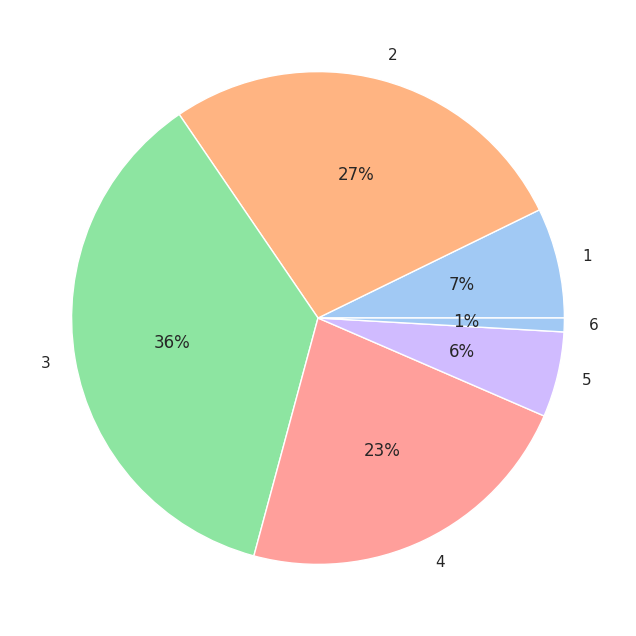

In [7]:
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(train['score'].unique())
dt = np.array([len(train[train['score'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

In [8]:
train['score'] = train['score'] - 1
train['full_text'] = train['full_text'].apply(lambda x: correct_punctuation(x))

In [9]:
train

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,2
1,000fe60,I am a scientist at NASA that is discussing th...,2
2,001ab80,People always wish they had the same technolog...,3
3,001bdc0,"We all heard about Venus, the planet without a...",3
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",2
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",1
17303,ffddf1f,Technology has changed a lot of ways that we l...,3
17304,fff016d,If you don't like sitting around all day than ...,1
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",0


# Divide into test and validation samples - Разделим на тестовые и валидационные выборки

In [10]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    train['full_text'],
    train['score'],
    test_size=0.2,
    shuffle=True,
    random_state=42
)

In [11]:
len(X_train), len(Y_train), len(X_valid), len(Y_valid)

(13845, 13845, 3462, 3462)

In [12]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [13]:
# save_directory = "/kaggle/working/tokenizer"
# tokenizer.save_pretrained(save_directory)

# load_directory = save_directory
tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/tokenizer-bert')

In [14]:
train_tokens = tokenizer(list(X_train), padding=True, truncation=True)
test_tokens = tokenizer(list(X_valid), padding=True, truncation=True)

In [15]:
train_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
print(train_tokens['input_ids'][0])
print(tokenizer.decode(train_tokens['input_ids'][0]))

[101, 1247, 1110, 1185, 2304, 1115, 1103, 3445, 2008, 1610, 1110, 170, 12675, 19024, 1107, 2052, 112, 188, 2808, 119, 1438, 1175, 1110, 170, 1304, 117, 1304, 13757, 3906, 1204, 2304, 1115, 1144, 1870, 1129, 2423, 3845, 119, 1109, 2304, 1110, 1142, 132, 1110, 1103, 1554, 1329, 1104, 170, 3445, 2008, 1610, 170, 3238, 12675, 19024, 136, 1109, 2590, 1110, 4208, 1106, 1142, 1696, 2304, 117, 1112, 1103, 3445, 2008, 1610, 1110, 170, 3238, 12675, 19024, 119, 1109, 1148, 2255, 1110, 1103, 13157, 12435, 27629, 17439, 170, 3445, 2008, 1610, 3272, 1115, 1156, 5257, 2808, 119, 1109, 1248, 2255, 1110, 1103, 3429, 1115, 170, 3445, 2008, 1610, 1180, 2906, 1191, 1122, 112, 188, 2063, 3106, 119, 2695, 1104, 1292, 3672, 1107, 1619, 1104, 1103, 3445, 2008, 1610, 1180, 5257, 2808, 1107, 1242, 3242, 119, 1109, 12675, 19024, 1104, 1103, 3445, 2008, 1610, 1110, 170, 3238, 1141, 1105, 1156, 5257, 2808, 119, 1109, 1718, 1880, 1104, 170, 3445, 2008, 1610, 1156, 2906, 13157, 185, 13159, 13292, 16652, 1115, 1156, 

2024-07-09 20:29:19.267697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 20:29:19.267808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 20:29:19.418039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[CLS] There is no question that the driverless car is a technological advancement in today's society. However there is a very, very importanat question that has yet be completely answered. The question is this ; is the full use of a driverless car a necessary technological advancement? The answer is yes to this important question, as the driverless car is a necessary technological advancement. The first reason is the infinite possibilities taht a driverless car offers that would benefit society. The second reason is the safety that a driverless car could offer if it's completed fully. Both of these reasons in support of the driverless car could benefit society in many ways. The technological advancement of the driverless car is a necessary one and would benefit society. The developmentment of a driverless car would offer infinite possiblities that would provide many important benefits. One such benefit is that the driver would have the ability to both rest and relax. some may argue tha

In [17]:
class TokenData(Dataset):
    def __init__(self, train=False):
        if train:
            self.text_data = X_train
            self.tokens = train_tokens
            self.labels = list(Y_train)
        else:
            self.text_data = X_valid
            self.tokens = test_tokens
            self.labels = list(Y_valid)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['labels'] = torch.tensor(self.labels[idx])
        return sample

# fit model

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

class Metrics:
    @staticmethod
    def f1_score_multiclass(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    @staticmethod
    def precision_multiclass(y_true, y_pred):
        return precision_score(y_true, y_pred, average='weighted')

    @staticmethod
    def recall_multiclass(y_true, y_pred):
        return recall_score(y_true, y_pred, average='weighted')

    @staticmethod
    def accuracy_multiclass(y_true, y_pred):
        return accuracy_score(y_true, y_pred)

In [19]:
batch_size = 16
train_dataset = TokenData(train=True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = TokenData(train=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [20]:
# model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=6)
model = BertForSequenceClassification.from_pretrained('/kaggle/input/model-bert')
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,
    weight_decay=2e-2,
    eps=1e-9,
    amsgrad=True
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=2) # StepLR(optimizer, step_size=1, gamma=0.1)
loss_function = torch.nn.CrossEntropyLoss()
metrics_functions = Metrics

In [21]:
# model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=6)
# save_directory = "/kaggle/working/model-bert"
# model.save_pretrained(save_directory)

In [22]:
# model = BertForSequenceClassification.from_pretrained(save_directory)
# model.to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# loss_function = torch.nn.CrossEntropyLoss()
# metrics_functions = Metrics

In [23]:
def train_one_epoch(data_loader, num_ep, metric_f: Metrics):
    global device, model, optimizer, loss_function, scheduler
    model.train(True)
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    print(f'Epoch train: {num_ep + 1}')
    print('-----------------------------------')
    for i, batch in enumerate(tqdm.notebook.tqdm(train_loader)):    
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        outputs = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))
        loss = loss_function(outputs.logits, batch['labels'])
        
        batch_size = batch['attention_mask'].size()[0]
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
        output_argmax = torch.argmax(outputs.logits, axis=1)
        metric_res['f1_score'] += metric_f.f1_score_multiclass(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
        metric_res['precision'] += metric_f.precision_multiclass(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
        metric_res['recall'] += metric_f.recall_multiclass(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
        metric_res['accuracy'] += metric_f.accuracy_multiclass(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
        
        loss.backward()
        optimizer.step()
        
    avg_loss = total_loss / total_samples
    print(f'loss train: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    return avg_loss, metric_res

In [24]:
def validation_one_epoch(data_loader, metric_f: Metrics):
    global device, model, loss_function
    model.eval()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    for i, batch in enumerate(tqdm.notebook.tqdm(test_loader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            
            loss = loss_function(outputs.logits, batch['labels'])

            batch_size = batch['attention_mask'].size()[0]
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            output_argmax = torch.argmax(outputs.logits, axis=1)
            metric_res['f1_score'] += metric_f.f1_score_multiclass(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            metric_res['precision'] += metric_f.precision_multiclass(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            metric_res['recall'] += metric_f.recall_multiclass(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            metric_res['accuracy'] += metric_f.accuracy_multiclass(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            
    avg_loss = total_loss / total_samples
    print(f'Loss validation: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    print('-----------------------------------')
    print()
    return avg_loss, metric_res

In [25]:
epoches = 16

train_losses = []
metric_res_train = {
        'f1_score': [],
        'precision': [],
        'recall': [],
        'accuracy': []
    }

valid_losses = []
metric_res_valid = {
        'f1_score': [],
        'precision': [],
        'recall': [],
        'accuracy': []
    }

for epoch in range(epoches):
    losses, metric_res = train_one_epoch(train_loader, epoch, metrics_functions)
    train_losses.append(losses)
    for i in metric_res:
        metric_res_train[i].append(metric_res[i])
    
    losses, metric_res = validation_one_epoch(test_loader, metrics_functions)
    valid_losses.append(losses)
    for i in metric_res:
        metric_res_valid[i].append(metric_res[i])
    
    scheduler.step(losses)

Epoch train: 1
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 1.0664975808733592
f1_score: 0.5264603010326214
precision: 0.5469921123577686
recall: 0.5654026724449259
accuracy: 0.5654026724449259


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0137500084596587
f1_score: 0.5453696505565495
precision: 0.5675688760177496
recall: 0.5782784517619873
accuracy: 0.5782784517619873
-----------------------------------

Epoch train: 2
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.8810149303688904
f1_score: 0.6041018862418162
precision: 0.6342477912521252
recall: 0.6236908631274829
accuracy: 0.6236908631274829


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 0.898377253890795
f1_score: 0.6097342479936207
precision: 0.6622142444499464
recall: 0.6143847487001733
accuracy: 0.6143847487001733
-----------------------------------

Epoch train: 3
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.7809947082392787
f1_score: 0.6573974806580988
precision: 0.6922824358739855
recall: 0.6704947634525099
accuracy: 0.6704947634525099


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 0.9329406304004081
f1_score: 0.594885178305681
precision: 0.651404229957089
recall: 0.5956094742923166
accuracy: 0.5956094742923166
-----------------------------------

Epoch train: 4
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.6732050313808376
f1_score: 0.7166026155894807
precision: 0.7553788908014257
recall: 0.7233658360418924
accuracy: 0.7233658360418924


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0141383499027607
f1_score: 0.5909002180179699
precision: 0.6435049825647745
recall: 0.5924321201617562
accuracy: 0.5924321201617562
-----------------------------------

Epoch train: 5
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.5310698853713505
f1_score: 0.7924841991106998
precision: 0.8244406245814704
recall: 0.7973997833152763
accuracy: 0.7973997833152763


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.1104152818279829
f1_score: 0.5803399837552147
precision: 0.6245649425675424
recall: 0.5909878682842288
accuracy: 0.5909878682842288
-----------------------------------

Epoch train: 6
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.3681511361511144
f1_score: 0.8802385943710498
precision: 0.899752829330296
recall: 0.8836403033586132
accuracy: 0.8836403033586132


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0491009950293482
f1_score: 0.6091688978644298
precision: 0.6571291648847974
recall: 0.6123627960716349
accuracy: 0.6123627960716349
-----------------------------------

Epoch train: 7
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.3457415475574974
f1_score: 0.8920884180132701
precision: 0.9089174675090167
recall: 0.894474539544962
accuracy: 0.894474539544962


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0535022070613091
f1_score: 0.610330467216396
precision: 0.6570152294589036
recall: 0.6138070479491623
accuracy: 0.6138070479491623
-----------------------------------

Epoch train: 8
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.3452425369354481
f1_score: 0.8917689372509605
precision: 0.9092364312786855
recall: 0.8939689418562659
accuracy: 0.8939689418562659


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0581153752761105
f1_score: 0.6084659532061485
precision: 0.656983218335038
recall: 0.6112073945696129
accuracy: 0.6112073945696129
-----------------------------------

Epoch train: 9
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.3390019027495393
f1_score: 0.894824745472888
precision: 0.9113514836754275
recall: 0.8971469844709281
accuracy: 0.8971469844709281


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0581368208620192
f1_score: 0.6084659532061485
precision: 0.656983218335038
recall: 0.6112073945696129
accuracy: 0.6112073945696129
-----------------------------------

Epoch train: 10
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.33594044960332975
f1_score: 0.8972853075547873
precision: 0.9136161204471072
recall: 0.8995305164319248
accuracy: 0.8995305164319248


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.05813570603823
f1_score: 0.6084659532061485
precision: 0.656983218335038
recall: 0.6112073945696129
accuracy: 0.6112073945696129
-----------------------------------

Epoch train: 11
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.3395271825043464
f1_score: 0.8984963842770037
precision: 0.9152197072619613
recall: 0.9005417118093174
accuracy: 0.9005417118093174


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0581890655555592
f1_score: 0.608818654717292
precision: 0.6573587238231952
recall: 0.6114962449451185
accuracy: 0.6114962449451185
-----------------------------------

Epoch train: 12
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.3373679482149019
f1_score: 0.8965196956315984
precision: 0.9123220285192112
recall: 0.899097146984471
accuracy: 0.899097146984471


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0582844356041572
f1_score: 0.6089245665216441
precision: 0.6573243368737303
recall: 0.6114962449451185
accuracy: 0.6114962449451185
-----------------------------------

Epoch train: 13
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.3359644131954933
f1_score: 0.8966188915604215
precision: 0.9126805386339514
recall: 0.8988082340195016
accuracy: 0.8988082340195016


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0583144407407319
f1_score: 0.6089337363748347
precision: 0.6572761951444793
recall: 0.6114962449451185
accuracy: 0.6114962449451185
-----------------------------------

Epoch train: 14
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.3378802291330511
f1_score: 0.8957572637607644
precision: 0.91340028516085
recall: 0.8981581798483207
accuracy: 0.8981581798483207


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.05833986227668
f1_score: 0.6089337363748347
precision: 0.6572761951444793
recall: 0.6114962449451185
accuracy: 0.6114962449451185
-----------------------------------

Epoch train: 15
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.33926960809668205
f1_score: 0.8933217391318582
precision: 0.9092293517645643
recall: 0.8962802455760203
accuracy: 0.8962802455760203


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.0583569965288173
f1_score: 0.6089337363748347
precision: 0.6572761951444793
recall: 0.6114962449451185
accuracy: 0.6114962449451185
-----------------------------------

Epoch train: 16
-----------------------------------


  0%|          | 0/866 [00:00<?, ?it/s]

loss train: 0.335543057185814
f1_score: 0.8958418351423721
precision: 0.9123842563279196
recall: 0.8981581798483207
accuracy: 0.8981581798483207


  0%|          | 0/217 [00:00<?, ?it/s]

Loss validation: 1.058374382353187
f1_score: 0.6089337363748347
precision: 0.6572761951444793
recall: 0.6114962449451185
accuracy: 0.6114962449451185
-----------------------------------



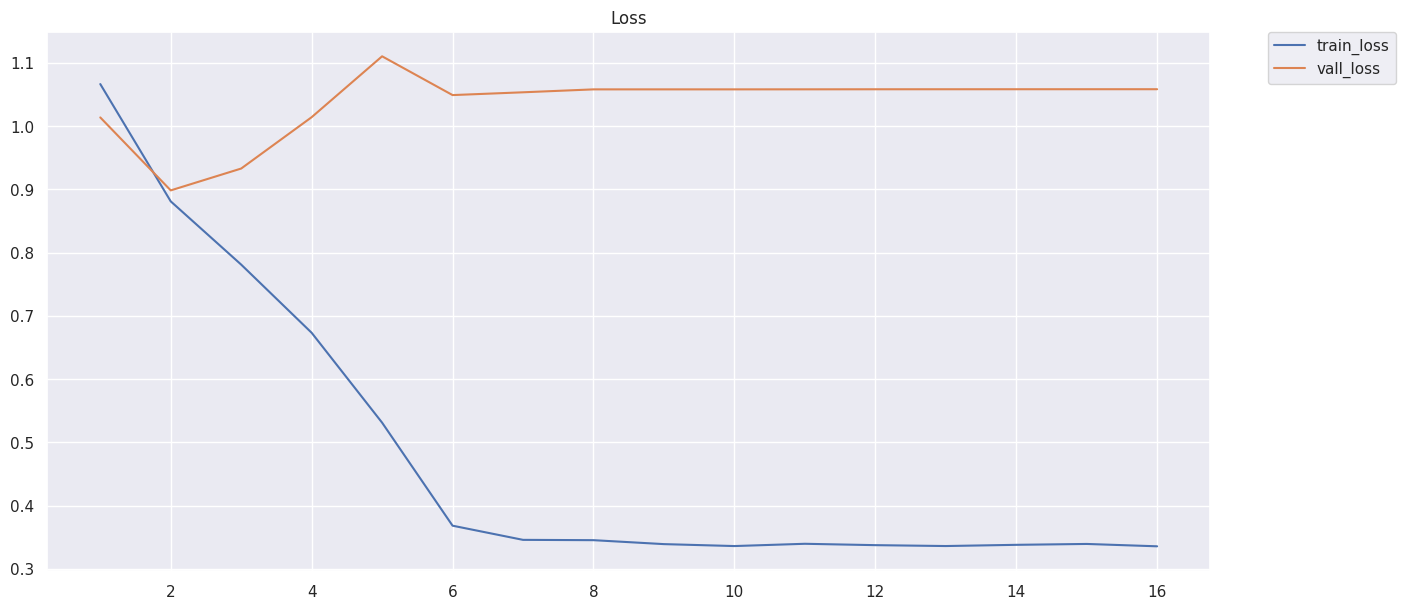

In [26]:
plt.figure(figsize=(15, 7))

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

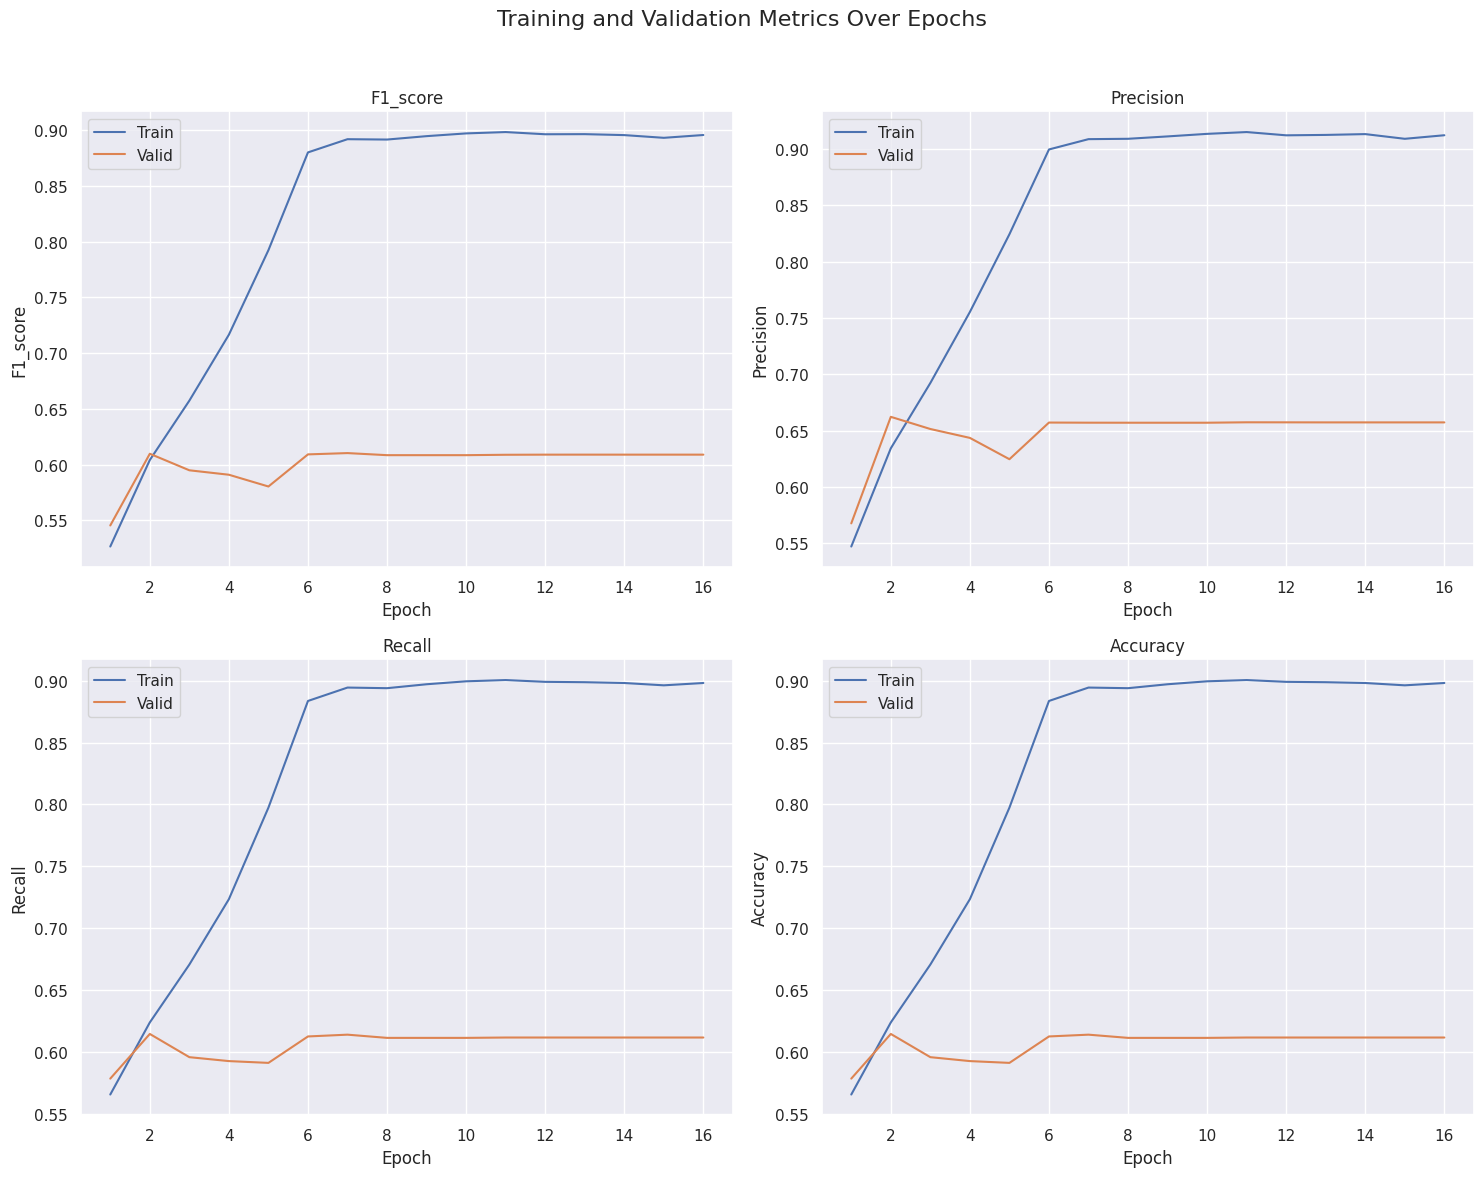

In [27]:
metrics = ['f1_score', 'precision', 'recall', 'accuracy']
epochs = range(1, len(metric_res_train['f1_score']) + 1)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(epochs, metric_res_train[metric], label='Train')
    ax.plot(epochs, metric_res_valid[metric], label='Valid')
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Test predict

In [28]:
test = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
test['full_text'] = test['full_text'].apply(lambda x: correct_punctuation(x))

In [29]:
test_tokens = tokenizer(list(test['full_text']), padding=True, truncation=True)

In [30]:
test_tokens_sample = {}
for k, v in test_tokens.items():
    test_tokens_sample[k] = torch.tensor(v).to(device)

In [31]:
batch_size = 16
test_loader_input_ids = DataLoader(test_tokens_sample['input_ids'], shuffle=False, batch_size=batch_size)
test_loader_attention_mask = DataLoader(test_tokens_sample['attention_mask'], shuffle=False, batch_size=batch_size)

In [32]:
# test_loader_input_ids

In [33]:
# print(len(test_loader_input_ids.dataset))

In [34]:
# test_loader_input_ids.dataset

In [35]:
# for batch in zip(test_loader_input_ids, test_loader_attention_mask):
#     break

In [36]:
# batch[0].size()

In [37]:
model.eval()
res = []
with torch.no_grad():
    for batch in tqdm.notebook.tqdm(zip(test_loader_input_ids, test_loader_attention_mask)):
        outputs = model(
            input_ids=batch[0],
            attention_mask=batch[1]
        )
        res.extend((torch.argmax(outputs.logits, axis=1).to('cpu') + 1).tolist())

0it [00:00, ?it/s]

In [38]:
submit = pd.DataFrame(
    {
        'essay_id': test['essay_id'],
        'score': res # torch.argmax(outputs.logits, axis=1).to('cpu') + 1
    }
)

In [39]:
submit

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,5


In [40]:
submit.to_csv('submission.csv', index=False)